<a href="https://colab.research.google.com/github/Pratik325/Language-Classification-with-Naive-Bayes-using-python/blob/master/Language_Classification_with_Naive_Bayes_using_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING THE REQUIRED PACKAGE**

In [0]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from tqdm import tqdm_notebook
import numpy as np
import string

from collections import defaultdict

from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

import joblib
import pickle as pkl

from helper_code import *

**EXPLORATORY DATA ANALYSIS + VISUALIZATION**

In [0]:
def open_file(filename):
    with open(filename, 'r') as f:
        data = f.readlines()
    return data

In [0]:
data_raw = dict()
data_raw['sk'] = open_file('/content/train_sentences.sk') 
data_raw['cs'] = open_file('/content/train_sentences.cs') 
data_raw['en'] = open_file('/content/train_sentences.en') 

In [0]:
def show_statistics(data):
    for language, sentences in data.items():
        
        number_of_sentences = 0
        number_of_words = 0
        number_of_unique_words = 0
        sample_extract = ''
        
        # take a few minutes to try populate these variables
        
        # here is a hint -- word_list breaks the collections of sentences into a list of words
        word_list = ' '.join(sentences).split()
        
        
        print(f'Language: {language}')
        print('-----------------------')
        print(f'Number of sentences\t:\t {number_of_sentences}')
        print(f'Number of words\t\t:\t {number_of_words}')
        print(f'Number of unique words\t:\t {number_of_unique_words}')
        print(f'Sample extract\t\t:\t {sample_extract}...\n')

In [5]:
show_statistics(data_raw)

Language: sk
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: cs
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: en
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...



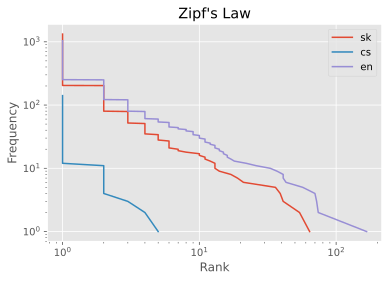

In [6]:
do_law_of_zipf(data = data_raw)

**DATA CLEANING AND PREPROCESSING**

In [0]:
def preprocess(text):
    '''
    Removes punctuation and digits from a string, and converts all characters to lowercase. 
    Also clears all \n and hyphens (splits hyphenated words into two words).
    
    '''
        
    preprocessed_text = text.lower().replace('-', ' ')
    
    translation_table = str.maketrans('\n', ' ', string.punctuation+string.digits)
    
    preprocessed_text = preprocessed_text.translate(translation_table)
        
    return preprocessed_text

In [0]:
data_preprocessed = {k: [preprocess(sentence) for sentence in v] for k, v in data_raw.items()}

In [9]:
print('Raw')
show_statistics(data_raw)

print('\nPreprocessed')
show_statistics(data_preprocessed)

Raw
Language: sk
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: cs
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: en
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...


Preprocessed
Language: sk
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: cs
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: en
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...



**NAIVE BAYES MODEL INTRODUCTION AND TRAINING**

In [0]:
sentences_train, y_train = [], []

for k, v in data_preprocessed.items():
    for sentence in v:
        sentences_train.append(sentence)
        y_train.append(k)

In [0]:
vectorizer = CountVectorizer()   #VECTORISING THE INPUTS

In [0]:
X_train = vectorizer.fit_transform(sentences_train)

In [13]:
X_train #VECTORISED

<210x2208 sparse matrix of type '<class 'numpy.int64'>'
	with 3867 stored elements in Compressed Sparse Row format>

**INITIALIZING MODEL PARAMETERS AND TRAINING**

In [14]:
naive_classifier = MultinomialNB()
naive_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**VECTORIZING VALIDATION DATA AND EVALUATING MODEL**

In [0]:
data_val = dict()
data_val['sk'] = open_file('/content/val_sentences.sk') 
data_val['cs'] = open_file('/content/val_sentences.cs') 
data_val['en'] = open_file('/content/val_sentences.en') 
data_val_preprocessed = {k: [preprocess(sentence) for sentence in v] for k, v in data_val.items()}

In [0]:
sentences_val, y_val = [], []

for k, v in data_val_preprocessed.items():
    for sentence in v:
        sentences_val.append(sentence)
        y_val.append(k)

In [0]:
X_val = vectorizer.transform(sentences_val)

In [0]:
predictions = naive_classifier.predict(X_val)

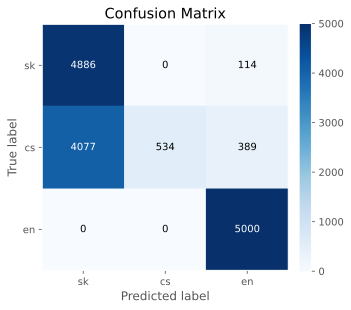

In [19]:
plot_confusion_matrix(y_val, predictions, [ 'sk','cs', 'en'])

In [20]:
f1_score(y_val, predictions, average='weighted')

0.6149824401040264

**Simple Adjustments and highlighting Model Shortcomings**

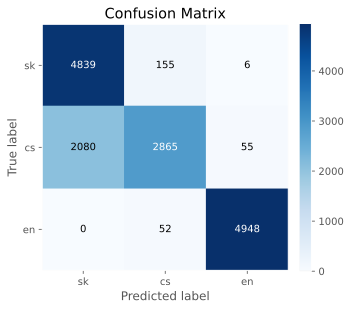

In [21]:
naive_classifier = MultinomialNB(alpha=0.0001, fit_prior=False)
naive_classifier.fit(X_train, y_train)

predictions = naive_classifier.predict(X_val)

plot_confusion_matrix(y_val, predictions, ['sk', 'cs', 'en'])

In [22]:
f1_score(y_val, predictions, average = 'weighted')   #we can see a huge difference

0.8368507601649364

**USING ADVANCED TECHNIQUES TO IMPROVE MODEL PERFORMANCE**

*USING SUBWORDS TO SHIFT PERSPECTIVE*
(Remove common characters that is repeating
and then make new data basically (SUBWORDS))

In [0]:
# taken from https://arxiv.org/abs/1508.07909

import re, collections
def get_stats(vocab):
    pairs = collections.defaultdict(int) 
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq 
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word] 
    return v_out

In [0]:
def get_vocab(data):

    words = []
    for sentence in data:
        words.extend(sentence.split())
        
    vocab = defaultdict(int)
    for word in words:
        vocab[' '.join(word)] += 1
        
    return vocab

In [0]:
vocab = get_vocab(sentences_train)

In [0]:
# also taken from original paper
for i in range(100):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get) 
    vocab = merge_vocab(best, vocab)

In [0]:
merges = defaultdict(int)
for k, v in vocab.items():
    for subword in k.split():
        if len(subword) >= 2:
            merges[subword] += v

In [0]:
merge_ordered = sorted(merges, key=merges.get, reverse=True)


In [0]:
pkl.dump(merge_ordered, open('/content/merge_ordered.pkl', 'wb'))

In [0]:
def split_into_subwords(text):
    merges = pkl.load(open('/content/merge_ordered.pkl', 'rb'))
    subwords = []
    for word in text.split():
        for subword in merges:
            subword_count = word.count(subword)
            if subword_count > 0:
                word = word.replace(subword, ' ')
                subwords.extend([subword]*subword_count)
    return ' '.join(subwords)

In [31]:
split_into_subwords("Hello my name is Pratik")

'lo na me is at'

In [0]:
data_preprocessed_subwords = {k: [split_into_subwords(sentence) for sentence in v] for k, v in data_preprocessed.items()}

In [33]:
show_statistics(data_preprocessed_subwords)

Language: sk
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: cs
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: en
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...



In [0]:
data_train_subwords = []
for sentence in sentences_train:
    data_train_subwords.append(split_into_subwords(sentence))

In [0]:
data_val_subwords = []
for sentence in sentences_val:
    data_val_subwords.append(split_into_subwords(sentence))

In [0]:
vectorizer = CountVectorizer()

In [37]:
naive_classifier = MultinomialNB(fit_prior=False)
naive_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

In [0]:
predictions = naive_classifier.predict(X_val)

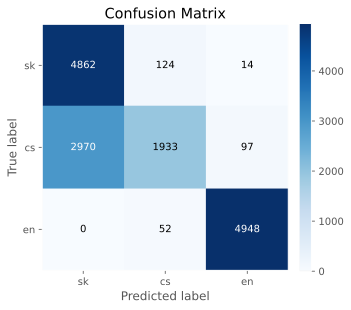

In [39]:
plot_confusion_matrix(y_val, predictions, ['sk', 'cs', 'en'])

In [40]:
f1_score(y_val, predictions, average='weighted')  #EVEN THOUGH MY ACC DID NOT IMPROVED Your ACC will surely increase

0.7618021064199549